# Dummy Variables and Treatment Effects

**Chapter 6, Section 2**

This notebook covers how dummy (indicator) variables in regression estimate treatment effects, and the interpretation of coefficients as conditional means.

## Table of Contents
1. [Intuition](#intuition) - Dummy = difference in means
2. [Formal Treatment](#formal) - Coefficient interpretation
3. [Numeric Demonstration](#numeric) - Wage and education examples
4. [Implementation](#implementation) - Visualizing parallel lines
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Simplest Regression: Treatment vs Control

Consider a binary treatment $T \in \{0, 1\}$. The simplest regression is:

$$Y_i = \alpha + \beta T_i + \epsilon_i$$

What does $\beta$ estimate?

- When $T = 0$: $E[Y | T=0] = \alpha$
- When $T = 1$: $E[Y | T=1] = \alpha + \beta$

Therefore:

$$\beta = E[Y | T=1] - E[Y | T=0]$$

**The dummy coefficient is simply the difference in means!**

★ Insight ─────────────────────────────────────
- Regression with a single dummy = difference in means
- The dummy coefficient estimates the Average Treatment Effect (ATE)
- This is the starting point for all regression-based causal inference
─────────────────────────────────────────────────

In [2]:
# Load wage data
wage = load_facure_data("wage.csv")

# Create a treatment dummy: high education (>12 years)
wage['high_educ'] = (wage['educ'] > 12).astype(int)

print(f"Treatment distribution:")
print(wage['high_educ'].value_counts())
print(f"\nProportion with high education: {wage['high_educ'].mean():.2%}")

Treatment distribution:
high_educ
0    481
1    454
Name: count, dtype: int64

Proportion with high education: 48.56%


In [3]:
# Method 1: Simple difference in means
mean_high = wage.loc[wage['high_educ'] == 1, 'wage'].mean()
mean_low = wage.loc[wage['high_educ'] == 0, 'wage'].mean()
diff_means = mean_high - mean_low

print("Method 1: Difference in Means")
print(f"  Mean wage (high educ): ${mean_high:.2f}")
print(f"  Mean wage (low educ):  ${mean_low:.2f}")
print(f"  Difference: ${diff_means:.2f}")

Method 1: Difference in Means
  Mean wage (high educ): $1076.02
  Mean wage (low educ):  $846.49
  Difference: $229.53


In [4]:
# Method 2: Regression with dummy
model_dummy = smf.ols('wage ~ high_educ', data=wage).fit()

print("\nMethod 2: Regression with Dummy")
print(f"  Intercept (mean low educ): ${model_dummy.params['Intercept']:.2f}")
print(f"  Coefficient (difference):  ${model_dummy.params['high_educ']:.2f}")


Method 2: Regression with Dummy
  Intercept (mean low educ): $846.49
  Coefficient (difference):  $229.53


In [5]:
# Verify they're identical
print("\n" + "=" * 50)
print("VERIFICATION: Methods produce identical results")
print("=" * 50)
print(f"Diff in means: ${diff_means:.6f}")
print(f"Regression β:  ${model_dummy.params['high_educ']:.6f}")
print(f"Match: {np.isclose(diff_means, model_dummy.params['high_educ'])}")


VERIFICATION: Methods produce identical results
Diff in means: $229.529427
Regression β:  $229.529427
Match: True


---

## Formal Treatment

### Adding Continuous Covariates

When we add a continuous covariate $X$:

$$Y_i = \alpha + \beta T_i + \gamma X_i + \epsilon_i$$

Now $\beta$ is the **conditional** treatment effect:

$$\beta = E[Y | T=1, X] - E[Y | T=0, X]$$

This represents the treatment effect **holding X constant**.

### The Parallel Lines Assumption

This model assumes:
- Treatment shifts the regression line **vertically** by $\beta$
- The **slope** with respect to X is the same ($\gamma$) for both groups
- The lines are **parallel**

$$
\begin{aligned}
E[Y | T=0, X] &= \alpha + \gamma X \\
E[Y | T=1, X] &= (\alpha + \beta) + \gamma X
\end{aligned}
$$

In [6]:
# Regression with dummy + continuous covariate
model_with_iq = smf.ols('wage ~ high_educ + IQ', data=wage).fit()

print("Regression: wage ~ high_educ + IQ")
print(ols_summary_table(model_with_iq)[['Coefficient', 'Std. Error', 'p-value']])

Regression: wage ~ high_educ + IQ
           Coefficient  Std. Error  p-value
Intercept     272.3595     89.6729   0.0025
high_educ     144.8476     28.0231   0.0000
IQ              6.0746      0.9309   0.0000


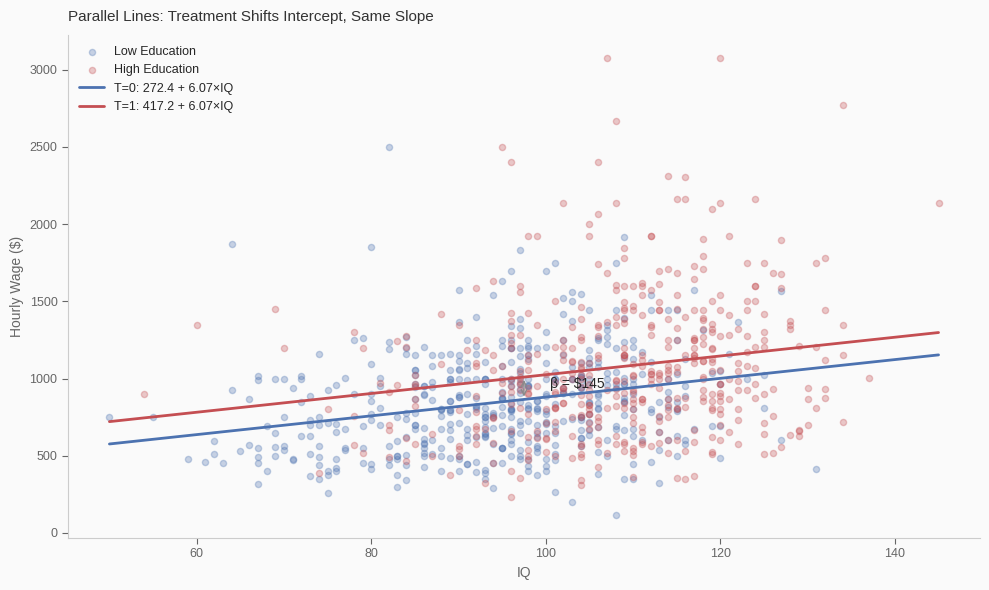

In [7]:
# Visualize parallel lines
fig, ax = create_tufte_figure(figsize=(10, 6))

# Plot data points
colors = {0: COLORS['blue'], 1: COLORS['red']}
for t_val in [0, 1]:
    subset = wage[wage['high_educ'] == t_val]
    label = 'High Education' if t_val == 1 else 'Low Education'
    ax.scatter(subset['IQ'], subset['wage'], alpha=0.3, c=colors[t_val], 
               s=20, label=label)

# Plot fitted lines (parallel)
iq_range = np.linspace(wage['IQ'].min(), wage['IQ'].max(), 100)
alpha = model_with_iq.params['Intercept']
beta = model_with_iq.params['high_educ']
gamma = model_with_iq.params['IQ']

y_low = alpha + gamma * iq_range
y_high = (alpha + beta) + gamma * iq_range

ax.plot(iq_range, y_low, color=COLORS['blue'], linewidth=2, label=f'T=0: {alpha:.1f} + {gamma:.2f}×IQ')
ax.plot(iq_range, y_high, color=COLORS['red'], linewidth=2, label=f'T=1: {alpha+beta:.1f} + {gamma:.2f}×IQ')

# Annotate the gap
mid_iq = (wage['IQ'].min() + wage['IQ'].max()) / 2
ax.annotate('', xy=(mid_iq, alpha + beta + gamma * mid_iq), 
            xytext=(mid_iq, alpha + gamma * mid_iq),
            arrowprops=dict(arrowstyle='<->', color=COLORS['gray']))
ax.text(mid_iq + 3, alpha + beta/2 + gamma * mid_iq, f'β = ${beta:.0f}', fontsize=10)

set_tufte_title(ax, "Parallel Lines: Treatment Shifts Intercept, Same Slope")
set_tufte_labels(ax, "IQ", "Hourly Wage ($)")
ax.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

---

## Numeric Demonstration

### Comparing Raw vs Adjusted Effects

How does controlling for IQ change our estimate of the education effect?

In [8]:
# Compare raw and adjusted effects
model_raw = smf.ols('wage ~ high_educ', data=wage).fit()
model_adj = smf.ols('wage ~ high_educ + IQ', data=wage).fit()

print("COMPARISON: Raw vs IQ-Adjusted Education Effect")
print("=" * 55)

comparison = pd.DataFrame({
    'Model': ['Raw (no controls)', 'Adjusted (+ IQ)'],
    'Effect': [
        model_raw.params['high_educ'],
        model_adj.params['high_educ']
    ],
    'Std Error': [
        model_raw.bse['high_educ'],
        model_adj.bse['high_educ']
    ],
    'R-squared': [
        model_raw.rsquared,
        model_adj.rsquared
    ]
})
comparison

COMPARISON: Raw vs IQ-Adjusted Education Effect


,Model,Effect,Std Error,R-squared
0,Raw (no controls),229.5294,25.3843,0.0806
1,Adjusted (+ IQ),144.8476,28.0231,0.1207


### Interpretation

1. **Effect decreases** when we control for IQ → IQ is positively correlated with both education AND wages (confounder)
2. **Standard error decreases** → controlling for a predictive variable (IQ) reduces residual variance
3. **R-squared increases** → model explains more variance

In [9]:
# Check correlation structure
print("Correlation between high_educ and IQ:")
corr = wage[['high_educ', 'IQ', 'wage']].corr()
print(corr)

Correlation between high_educ and IQ:
           high_educ     IQ   wage
high_educ     1.0000 0.4631 0.2839
IQ            0.4631 1.0000 0.3091
wage          0.2839 0.3091 1.0000


### Using Log Wages

In labor economics, we typically use **log wages** because:
1. Wage distributions are right-skewed
2. Coefficients have percentage interpretation (approximately)

In [10]:
# Compare raw wage vs log wage
model_level = smf.ols('wage ~ high_educ + IQ', data=wage).fit()
model_log = smf.ols('lhwage ~ high_educ + IQ', data=wage).fit()

print("Level wages: wage ~ high_educ + IQ")
print(f"  Education effect: ${model_level.params['high_educ']:.2f}/hour")

print("\nLog wages: log(wage) ~ high_educ + IQ")
print(f"  Education effect: {model_log.params['high_educ']:.4f}")
print(f"  ≈ {model_log.params['high_educ']*100:.1f}% wage premium")

Level wages: wage ~ high_educ + IQ
  Education effect: $144.85/hour

Log wages: log(wage) ~ high_educ + IQ
  Education effect: 0.1305
  ≈ 13.0% wage premium


---

## Implementation

### Creating Dummy Variables in Pandas

In [11]:
# Method 1: Boolean conversion
wage['dummy_method1'] = (wage['educ'] > 12).astype(int)

# Method 2: np.where
wage['dummy_method2'] = np.where(wage['educ'] > 12, 1, 0)

# Method 3: pd.cut for multiple categories
wage['educ_cat'] = pd.cut(wage['educ'], bins=[0, 9, 12, 16, 100], 
                          labels=['<HS', 'HS', 'Some College', 'College+'])

wage[['educ', 'dummy_method1', 'dummy_method2', 'educ_cat']].head(10)

,educ,dummy_method1,dummy_method2,educ_cat
0,12,0,0,HS
1,18,1,1,College+
2,14,1,1,Some College
3,12,0,0,HS
4,11,0,0,HS
5,16,1,1,Some College
6,10,0,0,HS
7,18,1,1,College+
8,15,1,1,Some College
9,12,0,0,HS


In [12]:
# Using categorical variables in regression (C() notation)
# This automatically creates dummies with one category as reference
model_cat = smf.ols('wage ~ C(educ_cat)', data=wage).fit()

print("Regression with categorical education levels:")
print(ols_summary_table(model_cat)[['Coefficient', 'Std. Error', 'p-value']])

Regression with categorical education levels:
                             Coefficient  Std. Error  p-value
Intercept                       774.3000    121.9931   0.0000
C(educ_cat)[T.HS]                73.7276    123.2813   0.5500
C(educ_cat)[T.Some College]     268.8653    123.6898   0.0300
C(educ_cat)[T.College+]         422.6588    128.1271   0.0010


In [13]:
# Verify: reference category is '<HS'
print("\nGroup means:")
group_means = wage.groupby('educ_cat', observed=True)['wage'].mean()
print(group_means)

print("\nVerification:")
print(f"Intercept = mean(<HS): {model_cat.params['Intercept']:.2f} vs {group_means['<HS']:.2f}")
print(f"HS coefficient = mean(HS) - mean(<HS): {model_cat.params['C(educ_cat)[T.HS]']:.2f} vs {group_means['HS'] - group_means['<HS']:.2f}")


Group means:
educ_cat
<HS             774.3000
HS              848.0276
Some College   1043.1653
College+       1196.9588
Name: wage, dtype: float64

Verification:
Intercept = mean(<HS): 774.30 vs 774.30
HS coefficient = mean(HS) - mean(<HS): 73.73 vs 73.73


---

## Interview Appendix

### Practice Questions

**Q1: What does a dummy coefficient estimate in a simple regression?**

<details>
<summary>Solution</summary>

In the regression $Y = \alpha + \beta T + \epsilon$ where T is binary:

- $\alpha$ = E[Y | T=0], the mean outcome in the control group
- $\beta$ = E[Y | T=1] - E[Y | T=0], the difference in means

The dummy coefficient is literally the difference in group means. This is the **naive ATE estimator**—it equals the true ATE only if treatment is randomly assigned (or conditional on covariates in a regression with controls).

</details>

**Q2: What does the parallel lines assumption mean, and when might it be violated?**

<details>
<summary>Solution</summary>

The parallel lines assumption means:
- The treatment effect is **constant** across all values of the covariate
- Treatment shifts the regression line vertically (changes intercept)
- Treatment does NOT change the slope

Violations occur when:
- Treatment effect varies by covariate value (effect heterogeneity)
- Example: A training program might help low-IQ workers more than high-IQ workers

To allow for heterogeneous effects, add an **interaction term**: $Y = \alpha + \beta_1 T + \beta_2 X + \beta_3 (T \times X) + \epsilon$

</details>

**Q3: Why does controlling for IQ reduce the education coefficient?**

<details>
<summary>Solution</summary>

IQ is a **confounder** in the education-wage relationship:
- High IQ → more likely to pursue education
- High IQ → higher wages (independent of education)

Without controlling for IQ, the education coefficient captures:
1. The true effect of education on wages
2. PLUS the spurious association from IQ

This is the **omitted variable bias formula**:
$$\beta_{short} = \beta_{long} + \gamma \times \delta$$

Where:
- $\gamma$ = effect of IQ on wages (positive)
- $\delta$ = correlation of IQ with education (positive)
- Bias = positive → raw estimate is biased upward

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 6.

[^2]: Angrist, J. D., & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*, Chapter 3.

[^3]: Cross-reference: `augmented/notebooks/05_linear_regression/04_omitted_variable_bias.ipynb` for OVB formula.